# Computational Finance

## Lab Assignment 2

This notebook makes use of a python 3 environment by default.

Authors:
- Kevin de Vries
- Jedda Boyle
- Krishnakanth Sasi

Student numbers:
- 10579869
- 11398221
- 11391952

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Keeps results reproducible
np.random.seed(23456)

# Part 1: Basic Option Valuation

In [7]:
def European(S0,K,r,sigma,T,N,Z,call,path):
    """
    Calculates the payoff of European option simulations
    """
    
    S_T = S0 * np.exp((r - sigma**2 / 2)*T + sigma*Z*np.sqrt(T))
    batch = np.maximum(0, S_T - K) if call else np.maximum(0,K - S_T)
    return batch

def MC_option_values(S0,K,r,sigma,T,N,M=100000,N_sim=30,
                     call=False,payoff=European,path=False,
                     antithetic=True,control_variable=None,control_analytic=None,stats=True):
    """
    Calculates a number of option values using a Monte Carlo method. 
    The option to use antithetic variables is on by default.
    
    The value is determined as the mean of a 
    batch of payoffs discounted with the interest rate.
    
    Returns the mean of the calculated options and its standard error
    
    call:
        Determines if call or put option
    payoff:
        Function which calculates the payoff of the option style
    path:
        Determines if the full path of the stock price has to be simulated.
    antithetic:
        Determines if to apply variance reduction using antithetic variables
    control_variable:
        Function with option payoff to be used as control variable
    control_analytic:
        Function with the black-scholes price of the control variable
    stats:
        Determines if the mean and standard error of the option values are returned
    """
    
    if path:
        Z = np.random.normal(0,1,(M,N_sim,N))
    else:
        Z = np.random.normal(0,1,(M,N_sim))
    
    batch = payoff(S0,K,r,sigma,T,N,Z,call,path)
    values = np.exp(-r*T) * np.mean(batch,axis=0)
    
    if antithetic:
        batch = payoff(S0,K,r,sigma,T,N,-Z,call,path)
        values_min = np.exp(-r*T) * np.mean(batch,axis=0)
        values = (values + values_min) / 2
    
    if control_variable:
        batch = control_variable(S0,K,r,sigma,T,N,Z,call,path)
        control = np.exp(-r*T) * np.mean(batch,axis=0)
    
        if antithetic:
            batch = control_variable(S0,K,r,sigma,T,N,-Z,call,path)
            control_min = np.exp(-r*T) * np.mean(batch,axis=0)
            control = (control + control_min) / 2
    
        # Calculate analytic control variate option valuation
        analytic, _ = control_analytic(S0,K,r,sigma,T,N)

        # Minimize scale variable beta
        control_centered = control-np.mean(control)
        beta = np.sum( (values-np.mean(values)) * control_centered ) / np.sum(control_centered**2)
        
        values = values - beta*(control-analytic)
    
    if stats:
        mean,std = data_stats(values)
        return values,mean,std
    else:
        return values
    
def data_stats(data):
    mean = np.mean(data)
    var = np.sum((data-mean)**2) / (data.size - 1)
    std_err = np.sqrt(var/data.size)
    return mean,std_err

In [2]:
def black_scholes_put_price(S_0, K, r, sigma, T):
    d1 = (np.log(S_0/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*(T**0.5) 
    return K*np.exp(-r*T)*norm.cdf(-d2) - S_0*norm.cdf(-d1)

def european_put_payoff(S_T, K):
    return np.maximum(0, K - S_T)
    
def MC_option_price(S_0, K, r, sigma, M, N, antithetic = False, payoff_func = european_put_payoff):
    Z = np.random.normal(0, 1, (M, N))
    S_T = S_0 * np.exp((r - sigma**2 / 2)*T + sigma*Z*np.sqrt(T))
    payoffs = payoff_func(S_T, K)
    discounted_mean_payoffs = np.exp(-r*T) * np.mean(payoffs,axis=0)
    
    if antithetic:
        S_T = S_0 * np.exp((r - sigma**2 / 2)*T + sigma*-Z*np.sqrt(T))
        payoffs = payoff_func(S_T, K)
        discounted_mean_payoffs_min = np.exp(-r*T) * np.mean(payoffs,axis=0)
        discounted_mean_payoffs = (discounted_mean_payoffs + discounted_mean_payoffs_min) / 2
        
    mean = np.mean(discounted_mean_payoffs)
    var = np.sum((discounted_mean_payoffs - mean)**2) / (discounted_mean_payoffs.size - 1)
    std_err = np.sqrt(var/discounted_mean_payoffs.size)
    return mean, np.std(discounted_mean_payoffs, ddof=1)

In [4]:
# Calculate European option value using Batch Monte Carlo
S_0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 30
M = 10000

# Option values and stats using mean payoffs
mean, std = MC_option_price(S_0, K, r, sigma, M, N, antithetic = False, payoff_func = european_put_payoff)

print("Mean: %f" % mean)
print("Standard error: %f" % std)

Mean: 4.789625
Standard error: 0.072617


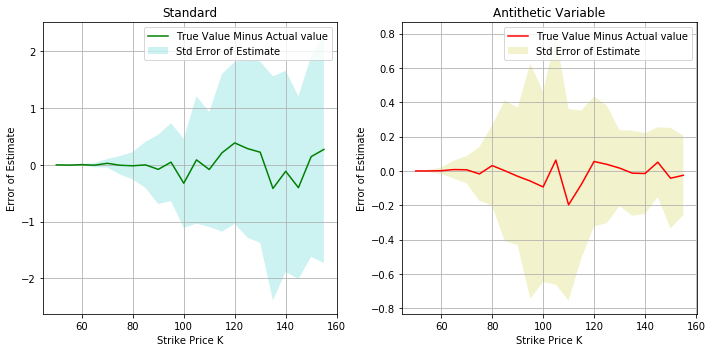

In [5]:
S_0   = 100
K     = 99
r     = 0.06 
sigma = 0.2
T     = 1
M     = 100
N     = 30
step = 5
domain = range(50, 160, step)
plt.figure(figsize=(10, 5))

std_errors = np.empty(len(domain))
abs_errors = np.empty(len(domain))

plt.subplot(1, 2, 1)
for i, K in enumerate(domain):
    correct_value = black_scholes_put_price(S_0, K, r, sigma, T)
    estimate, std_errors[i] = MC_option_price(S_0, K, r, sigma, M, N, antithetic = False)
    abs_errors[i] = correct_value - estimate 

plt.plot(domain, abs_errors, color='g', label='True Value Minus Actual value')
plt.fill_between(domain, abs_errors - std_errors, abs_errors + std_errors, facecolor='c', alpha=.2, label='Std Error of Estimate')
plt.title('Standard')
plt.ylabel('Error of Estimate')
plt.xlabel('Strike Price K')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)

for i, K in enumerate(domain):
    correct_value = black_scholes_put_price(S_0, K, r, sigma, T)
    estimate, std_errors[i] = MC_option_price(S_0, K, r, sigma, int(M/2), N, antithetic = True)
    abs_errors[i] = correct_value - estimate 

plt.plot(domain, abs_errors, color='r', label='True Value Minus Actual value')
plt.fill_between(domain, abs_errors - std_errors, abs_errors + std_errors, facecolor='y', alpha=.2, label='Std Error of Estimate')
plt.title('Antithetic Variable')
plt.ylabel('Error of Estimate')
plt.xlabel('Strike Price K')
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

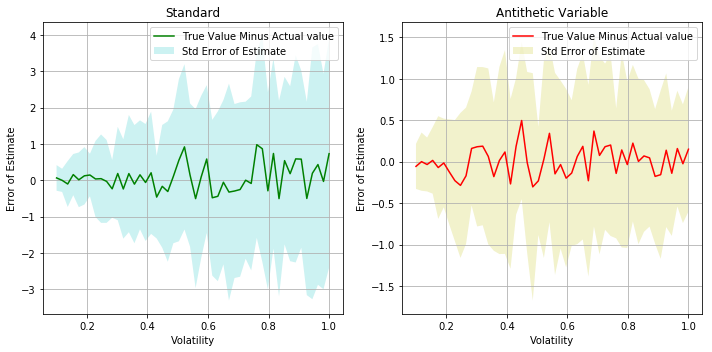

In [6]:
# define parameters for all experimentation
S_0   = 100
K     = 99
r     = 0.06 
sigma = 0.2
T     = 1
M     = 100
N     = 30

step = 5
domain = np.linspace(.1, 1, 50)
plt.figure(figsize=(10, 5))

std_errors = np.empty(len(domain))
abs_errors = np.empty(len(domain))

plt.subplot(1, 2, 1)
for i, sigma in enumerate(domain):
    correct_value = black_scholes_put_price(S_0, K, r, sigma, T)
    estimate, std_errors[i] = MC_option_price(S_0, K, r, sigma, M, N, antithetic = False)
    abs_errors[i] = correct_value - estimate 

plt.plot(domain, abs_errors, color='g', label='True Value Minus Actual value')
plt.fill_between(domain, abs_errors - std_errors, abs_errors + std_errors, facecolor='c', alpha=.2, label='Std Error of Estimate')
plt.title('Standard')
plt.ylabel('Error of Estimate')
plt.xlabel('Volatility')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)

for i, sigma in enumerate(domain):
    correct_value = black_scholes_put_price(S_0, K, r, sigma, T)
    estimate, std_errors[i] = MC_option_price(S_0, K, r, sigma, int(M/2), N, antithetic = True)
    abs_errors[i] = correct_value - estimate 

plt.plot(domain, abs_errors, color='r', label='True Value Minus Actual value')
plt.fill_between(domain, abs_errors - std_errors, abs_errors + std_errors, facecolor='y', alpha=.2, label='Std Error of Estimate')
plt.title('Antithetic Variable')
plt.ylabel('Error of Estimate')
plt.xlabel('Volatility')
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

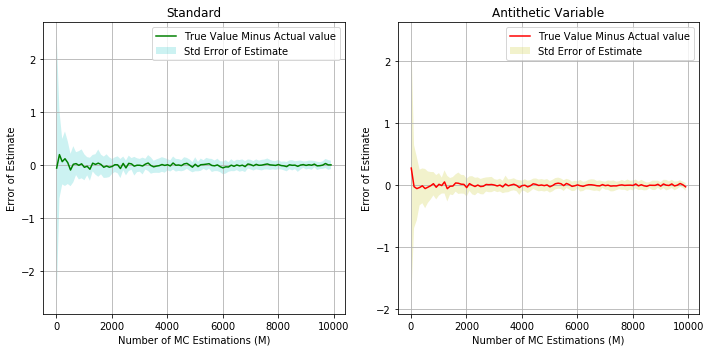

In [7]:
# define parameters for all experimentation
S_0   = 100
K     = 99
r     = 0.06 
sigma = 0.2
T     = 1
M     = 100
N     = 30

domain = range(10, 10000, 100)
plt.figure(figsize=(10, 5))

std_errors = np.empty(len(domain))
abs_errors = np.empty(len(domain))

plt.subplot(1, 2, 1)
for i, M in enumerate(domain):
    correct_value = black_scholes_put_price(S_0, K, r, sigma, T)
    estimate, std_errors[i] = MC_option_price(S_0, K, r, sigma, M, N, antithetic = False)
    abs_errors[i] = correct_value - estimate 

plt.plot(domain, abs_errors, color='g', label='True Value Minus Actual value')
plt.fill_between(domain, abs_errors - std_errors, abs_errors + std_errors, facecolor='c', alpha=.2, label='Std Error of Estimate')
plt.title('Standard')
plt.ylabel('Error of Estimate')
plt.xlabel('Number of MC Estimations (M)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for i, M in enumerate(domain):
    correct_value = black_scholes_put_price(S_0, K, r, sigma, T)
    estimate, std_errors[i] = MC_option_price(S_0, K, r, sigma, int(M/2), N, antithetic = True)
    abs_errors[i] = correct_value - estimate 

plt.plot(domain, abs_errors, color='r', label='True Value Minus Actual value')
plt.fill_between(domain, abs_errors - std_errors, abs_errors + std_errors, facecolor='y', alpha=.2, label='Std Error of Estimate')
plt.title('Antithetic Variable')
plt.ylabel('Error of Estimate')
plt.xlabel('Number of MC Estimations (M)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

# Part 2: Estimation of Sensitivities in MC

In [8]:
def digital_payoff(S_T, K):
    S_T[S_T < K] = 0; 
    S_T[S_T >=  K] = 1
    return S_T

def smooth_digital_payoff(S_T, K, scale=0.000001):
    for i in range(S_T.shape[0]):
        for j in range(S_T.shape[1]):
            S_T[i, j] = norm.cdf(S_T[i, j], loc=K, scale=scale)
    return S_T

def european_call_payoff(S_T, K):
    return np.maximum(0, S_T - K)

def european_put_payoff(S_T, K):
    return np.maximum(0, K - S_T)

def black_scholes_put_delta(S_0, K, r, sigma, T):
    d1 = (np.log(S_0/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1) - 1

def black_scholes_call_delta(S_0, K, r, sigma, T):
    d1 = (np.log(S_0/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1) 
    
def sim_values(S_0, K, r, sigma, M, N, payoff_func = european_call_payoff):
    Z = np.random.normal(0, 1, (M, N))
    S_T = S_0 * np.exp((r - sigma**2 / 2)*T + sigma*Z*np.sqrt(T))
    payoffs = payoff_func(S_T, K)   
    return np.exp(-r*T) * np.mean(payoffs,axis=0)
    
def estimate_delta(S_0, K, r, sigma, M, N, epsilon, payoff_func, same_seed = True):
    seed = np.random.randint(0, 100)
    np.random.seed(seed)
    values = sim_values(S_0, K, r, sigma, M, N, payoff_func = payoff_func)
    np.random.seed(seed if same_seed else seed + 10)
    bumped_values = sim_values(S_0 + epsilon, K, r, sigma, M, N, payoff_func = payoff_func)
    deltas = (bumped_values-values) / epsilon 
    return np.mean(deltas), np.std(deltas, ddof=1)

def estimate_delta_likelihood(S_0, K, r, sigma, M, N, payoff_func):
    Z = np.random.normal(0, 1, (M, N))
    S_T = S_0 * np.exp((r - sigma**2 / 2)*T + sigma*Z*np.sqrt(T))
    payoffs = payoff_func(S_T, K)
    results =  np.exp(-r * T) * payoffs * (Z / (S_0 * sigma * np.sqrt(T)))
    mc_estimates = np.mean(results, axis=0)
    return np.mean(mc_estimates), np.std(mc_estimates, ddof=1)

def estimate_delta_pathwise(S_0, K, r, sigma, M, N, scale=1.0):
    Z = np.random.normal(0, 1, (M, N))
    S_T = S_0 * np.exp((r - sigma**2 / 2)*T + sigma*Z*np.sqrt(T))
    results = np.exp(-r*T) * norm.pdf(S_T, K, scale) * S_T / S_0
    mc_estimates = np.mean(results, axis=0)
    return np.mean(mc_estimates), np.std(mc_estimates, ddof=1)

In [9]:
# Calculate European option value using Batch Monte Carlo
S_0, K = 100, 99
r, sigma = 0.06, 0.2
T, M = 1,1000
call = False
N = 30
eps = 0.001

estimate, std_delta = estimate_delta(S_0, K, r, sigma, M, N, eps, european_put_payoff, same_seed = False)
print("Different seeds:\n")
print("Hedge parameter estimate: %f" % estimate)
print("Hedge parameter standard error: %f\n" % std_delta)

# Same seed
estimate, std_delta = estimate_delta(S_0, K, r, sigma, M, N, eps, european_put_payoff, same_seed = True)
print("Same seeds:\n")
print("Hedge parameter estimate: %f" % estimate)
print("Hedge parameter standard error: %f\n" % std_delta)


Different seeds:

Hedge parameter estimate: -37.632970
Hedge parameter standard error: 312.461521

Same seeds:

Hedge parameter estimate: -0.324778
Hedge parameter standard error: 0.012042



-0.326264488265


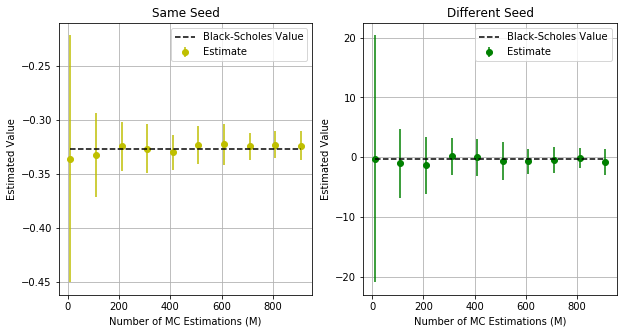

In [10]:
S_0   = 100
K     = 99
r     = 0.06 
sigma = 0.2
T     = 1
M     = 1000
N     = 30
epsilon = .5

correct_value = black_scholes_put_delta(S_0, K, r, sigma, T)
domain = range(10, 1000, 100)
correct_values = np.empty(len(domain))
print(correct_value)
for i, M in enumerate(domain):
    correct_values[i] = correct_value

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.grid()
plt.xlabel('Number of MC Estimations (M)')
plt.ylabel('Estimated Value')
plt.title('Same Seed')
estimates = np.empty(len(domain))
errors = np.empty(len(domain))
plt.plot(domain, correct_values, '--', color='k',label='Black-Scholes Value')
for epsilon in [.2]:
    relative_errors = np.empty(len(domain))
    for i, M in enumerate(domain):
        estimates[i], errors[i] = estimate_delta(S_0, K, r, sigma, M, N, epsilon, european_put_payoff, same_seed = True)
    plt.errorbar(domain, estimates, errors, fmt='o', barsabove=True, color='y', label='Estimate')
plt.legend()
plt.subplot(1,2,2)
plt.grid()

plt.xlabel('Number of MC Estimations (M)')
plt.title('Different Seed')
plt.ylabel('Estimated Value')
relative_errors = np.empty(len(domain))
plt.plot(domain, correct_values, '--', color='k',label='Black-Scholes Value')
for epsilon in [.2]:
    for i, M in enumerate(domain):
        estimates[i], errors[i] = estimate_delta(S_0, K, r, sigma, M, N, epsilon, european_put_payoff, same_seed = False)
    plt.errorbar(domain, estimates, errors, fmt='o', barsabove=True, color='g', label='Estimate')

plt.legend()
plt.show()

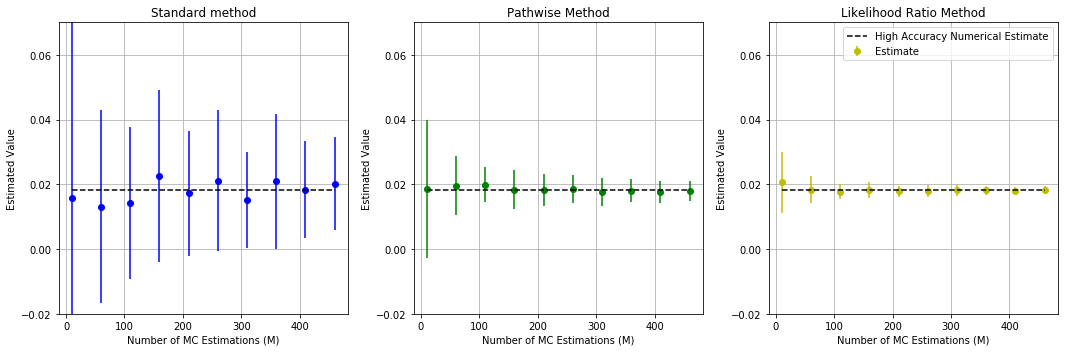

In [11]:
S_0   = 100
K     = 99
r     = 0.06 
sigma = 0.2
T     = 1
M     = 1000
N     = 30
epsilon = .5

correct_value = estimate_delta_likelihood(S_0, K, r, sigma, 10000, 1000, digital_payoff)[0]
domain = range(10, 500, 50)
correct_values = np.empty(len(domain))
for i, M in enumerate(domain):
    correct_values[i] = correct_value


plt.figure(figsize=(15,5))
estimates = np.empty(len(domain))
errors    = np.empty(len(domain))
epsilon = .2
seed = np.random.randint(0, 100)
plt.subplot(1,3,1)
plt.grid()
plt.xlabel('Number of MC Estimations (M)')
plt.title('Standard method')
plt.ylabel('Estimated Value')
plt.tight_layout()
plt.legend()
plt.ylim(-.02, .07)
plt.plot(domain, correct_values, '--', color='k',label='High Accuracy Numerical Estimate')
for i, M in enumerate(domain):
    estimates[i], errors[i]  = estimate_delta(S_0, K, r, sigma, M, N, epsilon, digital_payoff, same_seed = True)
plt.errorbar(domain, estimates, errors, fmt='o', barsabove=True, color='b', label='Estimate')

plt.subplot(1,3,2)
plt.ylim(-.02, .07)
plt.grid()
plt.xlabel('Number of MC Estimations (M)')
plt.title('Pathwise Method')
plt.ylabel('Estimated Value')
plt.tight_layout()
plt.legend()
plt.plot(domain, correct_values, '--', color='k',label='High Accuracy Numerical Estimate')
for i, M in enumerate(domain):
    estimates[i], errors[i]  = estimate_delta_pathwise(S_0, K, r, sigma, M, N, scale=1.0)
plt.errorbar(domain, estimates, errors, fmt='o', barsabove=True, color='g', label='Estimate')

plt.subplot(1,3,3)
plt.grid()
plt.ylim(-.02, .07)
plt.xlabel('Number of MC Estimations (M)')
plt.title('Likelihood Ratio Method')
plt.ylabel('Estimated Value')
plt.tight_layout()
plt.plot(domain, correct_values, '--', color='k',label='High Accuracy Numerical Estimate')
for i, M in enumerate(domain):
    estimates[i], errors[i]  = estimate_delta_likelihood(S_0, K, r, sigma, M, N, digital_payoff)
plt.errorbar(domain, estimates, errors, fmt='o', barsabove=True, color='y', label='Estimate')
plt.legend()
plt.show()

# Part 3: Variance Reduction

In [12]:
def European(S0,K,r,sigma,T,N,Z,call,path):
    """
    Calculates the payoff of European option simulations
    """
    
    S_T = S0 * np.exp((r - sigma**2 / 2)*T + sigma*Z*np.sqrt(T))
    batch = np.maximum(0, S_T - K) if call else np.maximum(0,K - S_T)
    return batch

def MC_option_values(S0,K,r,sigma,T,N,M=100000,N_sim=30,
                     call=False,payoff=European,path=False,
                     antithetic=True,control_variable=None,control_analytic=None,stats=True):
    """
    Calculates a number of option values using a Monte Carlo method. 
    The option to use antithetic variables is on by default.
    
    The value is determined as the mean of a 
    batch of payoffs discounted with the interest rate.
    
    Returns the mean of the calculated options and its standard error
    
    call:
        Determines if call or put option
    payoff:
        Function which calculates the payoff of the option style
    path:
        Determines if the full path of the stock price has to be simulated.
    antithetic:
        Determines if to apply variance reduction using antithetic variables
    control_variable:
        Function with option payoff to be used as control variable
    control_analytic:
        Function with the black-scholes price of the control variable
    stats:
        Determines if the mean and standard error of the option values are returned
    """
    
    if path:
        Z = np.random.normal(0,1,(M,N_sim,N))
    else:
        Z = np.random.normal(0,1,(M,N_sim))
    
    batch = payoff(S0,K,r,sigma,T,N,Z,call,path)
    values = np.exp(-r*T) * np.mean(batch,axis=0)
    
    if antithetic:
        batch = payoff(S0,K,r,sigma,T,N,-Z,call,path)
        values_min = np.exp(-r*T) * np.mean(batch,axis=0)
        values = (values + values_min) / 2
    
    if control_variable:
        batch = control_variable(S0,K,r,sigma,T,N,Z,call,path)
        control = np.exp(-r*T) * np.mean(batch,axis=0)
    
        if antithetic:
            batch = control_variable(S0,K,r,sigma,T,N,-Z,call,path)
            control_min = np.exp(-r*T) * np.mean(batch,axis=0)
            control = (control + control_min) / 2
    
        # Calculate analytic control variate option valuation
        analytic, _ = control_analytic(S0,K,r,sigma,T,N)

        # Minimize scale variable beta
        control_centered = control-np.mean(control)
        beta = np.sum( (values-np.mean(values)) * control_centered ) / np.sum(control_centered**2)
        
        values = values - beta*(control-analytic)
    
    if stats:
        mean,std = data_stats(values)
        return values,mean,std
    else:
        return values
    
def data_stats(data):
    mean = np.mean(data)
    var = np.sum((data-mean)**2) / (data.size - 1)
    std_err = np.sqrt(var/data.size)
    return mean,std_err



def geometric_Asian(S0,K,r,sigma,T,N,Z,call,path):
    """
    Calculates the payoff of geometric Asian option simulations
    """
    if path:
        dt = T / N
    
        mu = (r-0.5*sigma**2)*dt
        std = sigma*np.sqrt(dt)
    
        M, N_sim, _ = Z.shape
        batch = np.zeros((M,N_sim))
    
        S = np.zeros(N+1)
        S[0] = S0
        for m in range(M):
            for n in range(N_sim):
                for i in range(1,N+1):
                    S[i] = S[i-1]*np.exp(mu + std*Z[m,n,i-1])
                S_G = np.prod(S[1:]**(1/N))
                batch[m,n] = max(0,S_G - K) if call else max(0,K - S_G)
    
    else:
        mu = (r-0.5*sigma**2) * (N+1) * T / (2*N)
        std = sigma * np.sqrt((N+1) * (2*N+1) * T / (6*N**2))
        
        S_G = S0*np.exp(mu + std*Z)
        batch = np.maximum(0, S_G - K) if call else np.maximum(0,K - S_G)
    
    return batch

def arithmetic_Asian(S0,K,r,sigma,T,N,Z,call,path):
    """
    Calculates the payoff of arithmetic Asian option simulations
    """
    
    dt = T / N
    
    mu = (r-0.5*sigma**2)*dt
    std = sigma*np.sqrt(dt)
    
    M, N_sim, _ = Z.shape
    batch = np.zeros((M,N_sim))
    
    S = np.zeros(N+1)
    S[0] = S0
    for m in range(M):
        for n in range(N_sim):
            for i in range(1,N+1):
                S[i] = S[i-1]*np.exp(mu + std*Z[m,n,i-1])
            S_A = np.mean(S[1:])
            batch[m,n] = max(0,S_A - K) if call else max(0,K - S_A)
    
    return batch

def black_scholes_geometric_asian(S0,K,r,sigma,T,N,call=False):
    mu = (r-0.5*sigma**2) * (N+1) * T / (2*N)
    std = sigma * np.sqrt((N+1) * (2*N+1) * T / (6*N**2))
    
    d2 = (np.log(S0/K) + mu) / std
    d1 = d2 + std
    
    discount = np.exp(mu+0.5*std**2-r*T)
    if call:
        price = S0*discount*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        delta = discount*norm.cdf(d1)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S0*discount*norm.cdf(-d1)
        delta = -discount*norm.cdf(-d1)
    
    return price,delta

In [13]:
# Calculate Asian option value using Batch Monte Carlo
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 12
M, N_sim = 1000000, 30

eps = 0.001

seed = 12

for call in [True,False]:
    np.random.seed(seed)
    unbumped = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,call,payoff=geometric_Asian)
    np.random.seed(seed)
    bumped = MC_option_values(S0+eps,K,r,sigma,T,N,M,N_sim,call,payoff=geometric_Asian)

    # Calculate delta from estimate means
    deltas = (bumped[0]-unbumped[0]) / eps

    mu_delta,std_delta = data_stats(deltas)

    print("Asian geometric %s\n" % ("call" if call else "put"))
    
    print("Mean: %f" % unbumped[1])
    print("Standard error: %f\n" % unbumped[2])
    print("Hedge parameter estimate: %f" % mu_delta)
    print("Hedge parameter standard error: %f\n" % std_delta)

    price,delta = black_scholes_geometric_asian(S0,K,r,sigma,T,N,call)

    print("Black-Scholes price: %f" % price)
    print("Black-Scholes delta: %f\n" % delta)

Asian geometric call

Mean: 6.752416
Standard error: 0.000695

Hedge parameter estimate: 0.628818
Hedge parameter standard error: 0.000027

Black-Scholes price: 6.752147
Black-Scholes delta: 0.628809

Asian geometric put

Mean: 3.021051
Standard error: 0.000518

Hedge parameter estimate: -0.340842
Hedge parameter standard error: 0.000028

Black-Scholes price: 3.020874
Black-Scholes delta: -0.340850



In [14]:
# Analysis convergence geometric Asian option price

S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 12
N_sim = 30

analytic, _ = black_scholes_geometric_asian(S0,K,r,sigma,T,N,call=False)

M_vals = list(range(100,1000,100)) + list(range(1000,100001,1000))
stats = np.zeros((len(M_vals), 2))
for i in range(len(M_vals)):
    _,mean,std = MC_option_values(S0,K,r,sigma,T,N,M_vals[i],N_sim,
                                  call=False,payoff=geometric_Asian)
    
    stats[i,:] = mean, std

Black-Scholes price: 3.020874
MC price estimate: 3.020630
MC price standard error: 0.002220


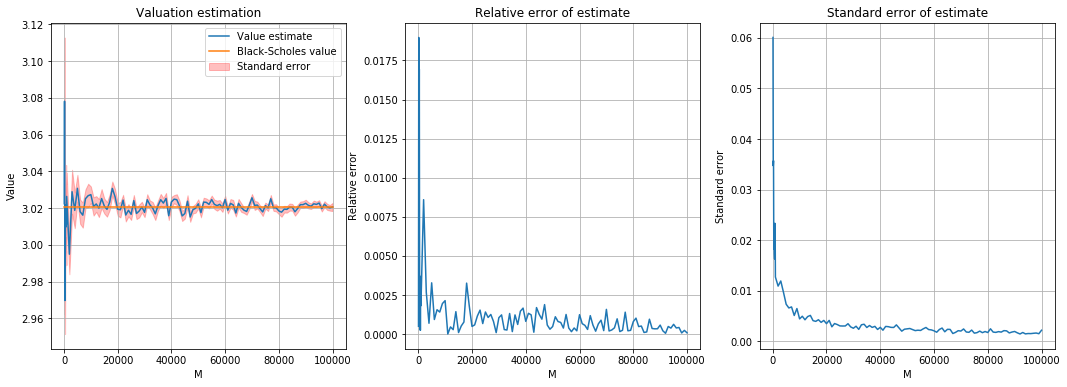

In [15]:
# Plot analysis results

print("Black-Scholes price: %f" % analytic)
print("MC price estimate: %f" % stats[-1,0])
print("MC price standard error: %f" % stats[-1,1])

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title("Valuation estimation")
plt.xlabel("M")
plt.ylabel("Value")
plt.grid()
plt.plot(M_vals,stats[:,0],label="Value estimate")
plt.fill_between(M_vals,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],
                 color='r',alpha=0.25,label="Standard error")

plt.plot([0,M_vals[-1]],[analytic,analytic],label="Black-Scholes value")
plt.legend()
plt.subplot(1,3,2)
plt.title("Relative error of estimate")
plt.xlabel("M")
plt.ylabel("Relative error")
plt.grid()
plt.plot(M_vals,abs((stats[:,0]-analytic) / analytic))
plt.subplot(1,3,3)
plt.title("Standard error of estimate")
plt.xlabel("M")
plt.ylabel("Standard error")
plt.grid()
plt.plot(M_vals,stats[:,1])
plt.show()

In [16]:
# Control variate test
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 12
M, N_sim = 100000, 30

seed = 123
np.random.seed(seed)

# Arithmetic Asian option
arithmetic = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,
                              payoff=arithmetic_Asian,path=True,antithetic=False)

print("Arithmetic normal:\n")
print("Mean: %f" % arithmetic[1])
print("Standard error: %f\n" % arithmetic[2])

# Arithmetic Asian option with control variable
control = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,
                           payoff=arithmetic_Asian,path=True,antithetic=False,
                           control_variable=geometric_Asian,
                           control_analytic=black_scholes_geometric_asian)

"""
cov = np.sum( (arithmetic[0]-arithmetic[1]) * geo_centered ) / (N_sim-1)
varX = np.sum((arithmetic[0]-arithmetic[1])**2) / (N_sim-1)
varY = np.sum(geo_centered**2) / (N_sim-1)
corr = cov / np.sqrt(varX*varY)

print("Correlation: %f\n" % corr)
"""

print("Arithmetic with control variable:\n")
print("Mean: %f" % control[1])
print("Standard error: %f\n" % control[2])

Arithmetic normal:

Mean: 2.912722
Standard error: 0.003276

Arithmetic with control variable:

Mean: 2.917360
Standard error: 0.000047



In [17]:
# Analysis convergence arithmetic Asian option price

S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 12
N_sim = 30

M_vals = list(range(10,100,10)) + list(range(100,1000,100)) + list(range(1000,10001,1000))

np.random.seed(12345)

In [18]:
# Normal arithmetic asian option
arithmetic = np.zeros((len(M_vals), 2))
for i in range(len(M_vals)):
    _,mean,std = MC_option_values(S0,K,r,sigma,T,N,M_vals[i],N_sim,
                                  call=False,path=True,antithetic=False,payoff=arithmetic_Asian)
    
    arithmetic[i,:] = mean, std

print("Done")

Done


In [19]:
# Arithmetic asian option with control variates
control = np.zeros((len(M_vals), 2))
for i in range(len(M_vals)):
    _,mean,std = MC_option_values(S0,K,r,sigma,T,N,M_vals[i],N_sim,
                                  call=False,payoff=arithmetic_Asian,path=True,antithetic=False,
                                  control_variable=geometric_Asian,
                                  control_analytic=black_scholes_geometric_asian)
    
    control[i,:] = mean, std

print("Done")

Done


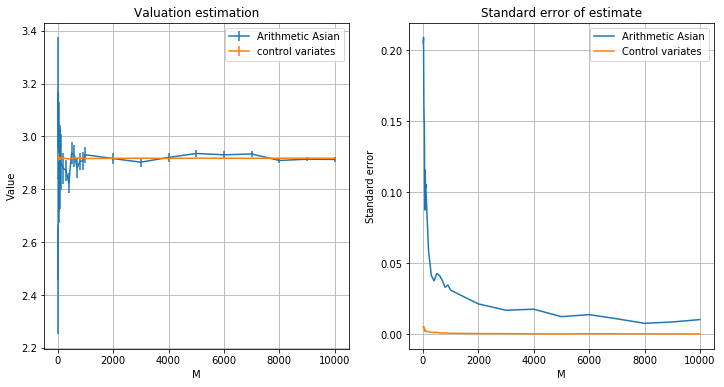

In [20]:
# Plot analysis results

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Valuation estimation")
plt.xlabel("M")
plt.ylabel("Value")
plt.grid()

plt.errorbar(M_vals,arithmetic[:,0],arithmetic[:,1],label="Arithmetic Asian")
"""
plt.plot(M_vals,arithmetic[:,0],'o-',label="Arithmetic Asian")
plt.fill_between(M_vals,arithmetic[:,0]+arithmetic[:,1],arithmetic[:,0]-arithmetic[:,1],
                 color='r',alpha=0.25,label="Arithmetic Asian standard error")
"""

plt.errorbar(M_vals,control[:,0],control[:,1],label="control variates")
"""
plt.plot(M_vals,control[:,0],'o-',label="control variates")
plt.fill_between(M_vals,control[:,0]+control[:,1],control[:,0]-control[:,1],
                 color='b',alpha=0.25,label="Control variates standard error")
"""

plt.legend()
plt.subplot(1,2,2)
plt.title("Standard error of estimate")
plt.xlabel("M")
plt.ylabel("Standard error")
plt.grid()
plt.plot(M_vals,arithmetic[:,1],label="Arithmetic Asian")
plt.plot(M_vals,control[:,1],label="Control variates")
plt.legend()

plt.show()